# Vehicle Detection and Tracking using HOG + SVM

Here we will train a SVM classifier that uses HOG features and other traditional techniques to detect Vehicles in a video.

In [1]:
import glob
import seaborn

# To display pd.DataFrames beautifully
from IPython.display import display, HTML

# display plot in the notebook
%matplotlib inline

# load my utils
from imp import reload
import detect_track.feature_extractor
reload(detect_track.feature_extractor); from detect_track.feature_extractor import *

## Configurations

In [2]:
# Configurations - Tweak these parameters to fine tune results.
color_space = 'YUV'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 4  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 0  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

## Load Dataset

In [3]:
# Read in cars and notcars
images = glob.glob('../data/*/*/*.png')

cars = []
notcars = []
for image in images:
    if 'non-vehicles' in image:
        notcars.append(image)
    else:
        cars.append(image)

print("Cars:", len(cars))
print("Not Cars:", len(notcars))

Cars: 8792
Not Cars: 9666


It's a balanced dataset

## Visualize Data

In [4]:
# helper method
def get_random_image(image_paths):
    random_index = np.random.randint(len(image_paths))
    image_path = image_paths[random_index]
    img = cv2.imread(image_path)
    return img

def read_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def show_samples(data, title):
    plt.figure(figsize=(10, 4))
    img_num = 1
    show_samples_count = 5

    for i in range(show_samples_count):
        plt.subplot(1, show_samples_count, img_num)   
        img_num += 1
        img = get_random_image(data)
        plt.imshow(img)
        plt.title("{}".format(title), fontsize=10)
        plt.axis('off')

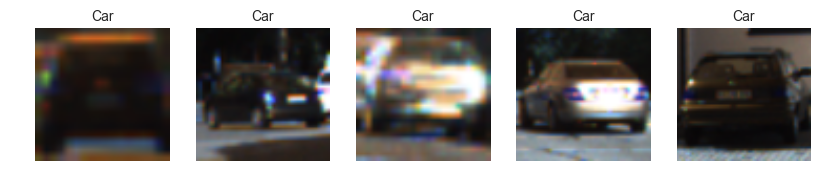

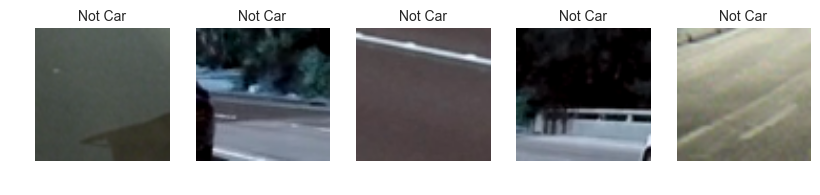

In [5]:
show_samples(cars, "Car")
show_samples(notcars, "Not Car")

### Visualize: Hog Features

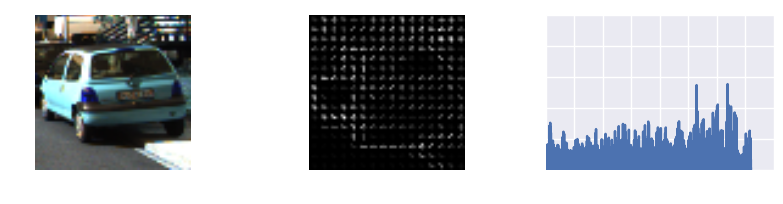

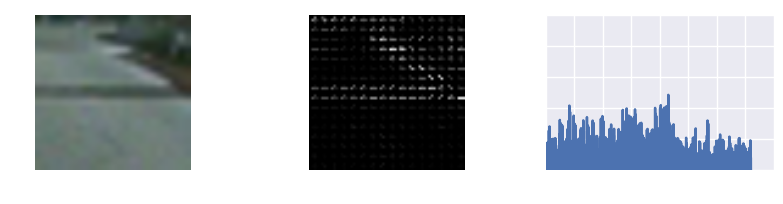

In [6]:
def plot_hog_sample(image, hog_image, hog_features):
    plt.figure(figsize=(10,2))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.plot(hog_features)
    plt.ylim(0,1)
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.show()

# plot positive image
image = get_random_image(cars)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hog_features, hog_image = get_hog_features(gray_image, orient=orient, 
                                           pix_per_cell=pix_per_cell, 
                                           cell_per_block=cell_per_block, vis=True)
plot_hog_sample(image, hog_image, hog_features)

# plot negative image
image = get_random_image(notcars)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hog_features, hog_image = get_hog_features(gray_image, orient=orient, 
                                           pix_per_cell=pix_per_cell, 
                                           cell_per_block=cell_per_block, vis=True)
plot_hog_sample(image, hog_image, hog_features)

### Visualize: Color histogram

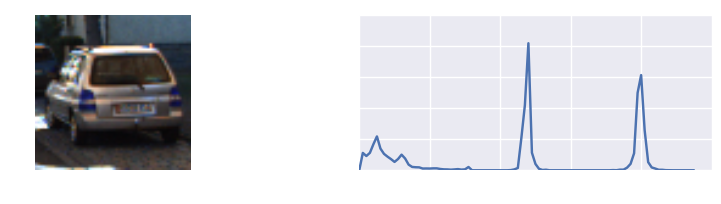

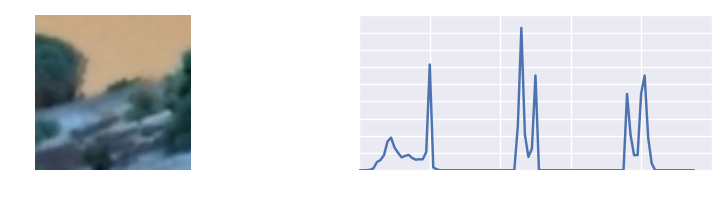

In [7]:
def plot_color_histogram_sample(image, yuv_image):
    plt.figure(figsize=(10,2))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.plot(color_hist(yuv_image))
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.show()
    
# plot positive image
image = get_random_image(cars)
yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
plot_color_histogram_sample(image, yuv_image)

# plot negative image
image = get_random_image(notcars)
yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
plot_color_histogram_sample(image, yuv_image)

### Visualize: Binned color

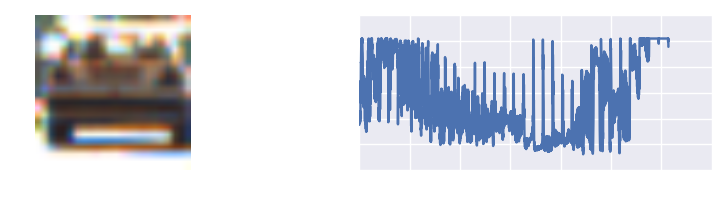

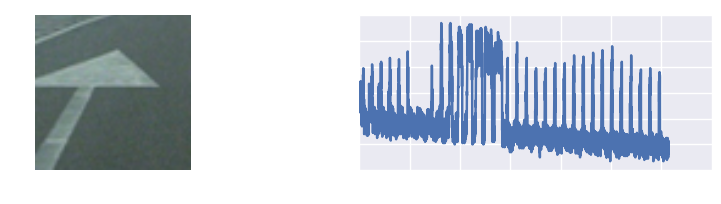

In [8]:
def plot_bin_spatial_sample(image):
    plt.figure(figsize=(10,2))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.plot(bin_spatial(image))
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.show()

# plot positive image
image = get_random_image(cars)
plot_bin_spatial_sample(image)

# plot negative image
image = get_random_image(notcars)
plot_bin_spatial_sample(image)

## Feature Extraction and Scaling

In [9]:
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("car_features:", len(car_features))

notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("notcar_features:", len(notcar_features))

X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print("Feature Scaling Complete")

car_features: 8792
notcar_features: 9666
Feature Scaling Complete


## Apply PCA reduction

In [10]:
# PCA
from sklearn.decomposition import RandomizedPCA, PCA
n_comp = 25
pca = PCA(n_components=n_comp, whiten=True)
pca = pca.fit(scaled_X)
pca_features = pca.transform(scaled_X)

## Plot PCA

Total explained variance by 25 principal components: 0.3002


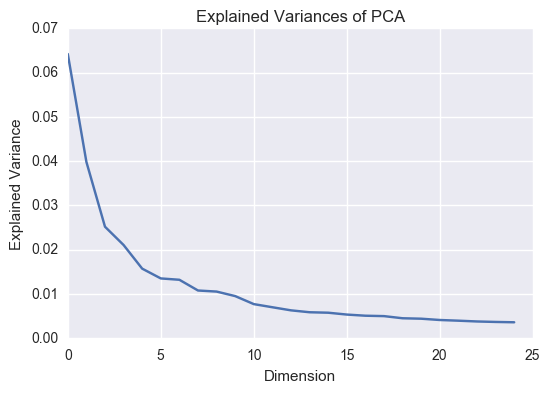

In [11]:
explained_variance = pca.explained_variance_ratio_
components = pca.components_

print("Total explained variance by {} principal components: {:.4f}".format(n_comp, sum(explained_variance[:n_comp])))

# plot pca
plt.xlabel('Dimension')
plt.ylabel('Explained Variance')
plt.title("Explained Variances of PCA")
_ = plt.plot(pca.explained_variance_ratio_)

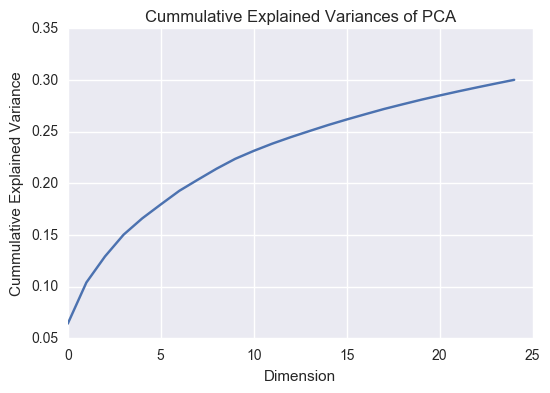

In [12]:
plt.xlabel('Dimension')
plt.ylabel('Cummulative Explained Variance')
plt.title("Cummulative Explained Variances of PCA")
_ = plt.plot(np.cumsum(pca.explained_variance_ratio_))

## Split Train Test dataset

In [13]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    pca_features, y, test_size=0.2, random_state=rand_state)

print("X_train:", len(X_train))
print("X_test:", len(X_test))
print("y_train:", len(y_train))
print("y_test:", len(y_test))

X_train: 14766
X_test: 3692
y_train: 14766
y_test: 3692


## Train SVM classifier

In [14]:
print('Using:', orient, 'orientations', pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
from sklearn.svm import SVC
svc = SVC(kernel='rbf', class_weight='balanced',probability=True, C = 10,gamma = 0.1)

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
predictions = svc.predict(X_test)

Using: 8 orientations 4 pixels per cell and 2 cells per block
Feature vector length: 25
13.61 Seconds to train SVC...
Test Accuracy of SVC =  0.9949


## Save Model

In [16]:
import os

# artifacts folder
GEN_FOLDER = '../model'
if not os.path.exists(GEN_FOLDER):
    os.makedirs(GEN_FOLDER)
    
from sklearn.externals import joblib

## save svc
fn = GEN_FOLDER + '/svc.pkl'
joblib.dump(svc, fn) 

## save pca
fn = GEN_FOLDER + '/pca.pkl'
joblib.dump(pca, fn) 

## save pca
fn = GEN_FOLDER + '/x_scaler.pkl'
joblib.dump(X_scaler, fn) 

print('svc, pca, x_scaler saved')

svc, pca, x_scaler saved


## Load Model

In [17]:
# load svm classifiers
svc = joblib.load(GEN_FOLDER + '/svc.pkl') 
pca = joblib.load(GEN_FOLDER + '/pca.pkl') 
X_scaler = joblib.load(GEN_FOLDER + '/x_scaler.pkl') 

print(svc, '\n')
print(pca, '\n')
print(X_scaler, '\n')

SVC(C=10, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma=0.1, kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False) 

PCA(copy=True, n_components=25, whiten=True) 

StandardScaler(copy=True, with_mean=True, with_std=True) 



## Test Image

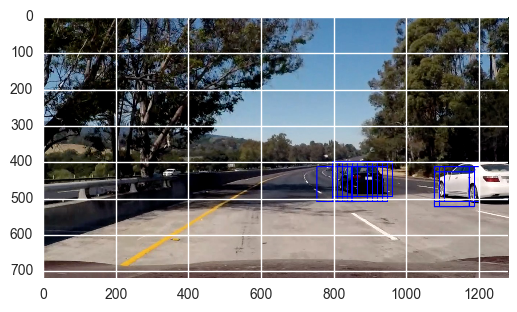

In [21]:
from car_finder import CarFinder

test_fn = '../test_images/test5.jpg'
image = mpimg.imread(test_fn)
window_img = CarFinder().process_frame(image, show_detections=True)
_ = plt.imshow(window_img)

## Metrics and Confusion matrix

In [22]:
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=None):

    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=cmap)
    
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

    plt.title(title+ "\n")
    fig.colorbar(cax)
    if labels:
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(GEN_FOLDER + '/confusionmatrix.png')

accuracy_score: 0.994853737811
f1_score: 0.99450390512
precision_score: 0.998257839721
recall_score: 0.990778097983


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning)
//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:976: DeprecationWarning: From version 0.18, binary input will not be handled specially when using averaged precision/recall/F-score. Please use average='binary' to report only the positive class performance.
  'positive class performance.', DeprecationWarning

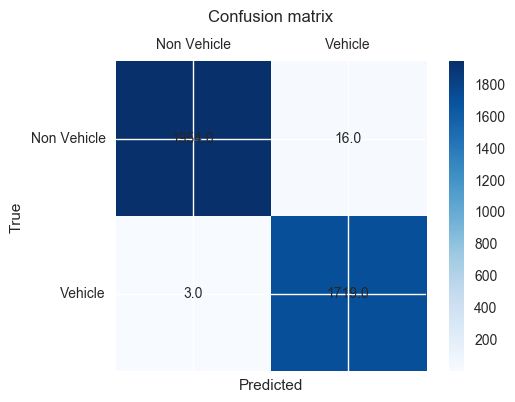

In [24]:
# calculate metrics
print("accuracy_score:", accuracy_score(y_test, predictions))
print("f1_score:", f1_score(y_test, predictions, average="macro"))
print("precision_score:", precision_score(y_test, predictions, average="macro"))
print("recall_score:", recall_score(y_test, predictions, average="macro")) 

# sklearn confusion matrix 
cm = confusion_matrix(predictions, y_test)

# plot using matplotlib
plot_confusion_matrix(cm, labels = ['Non Vehicle', 'Vehicle'])

## Plot ROC curve

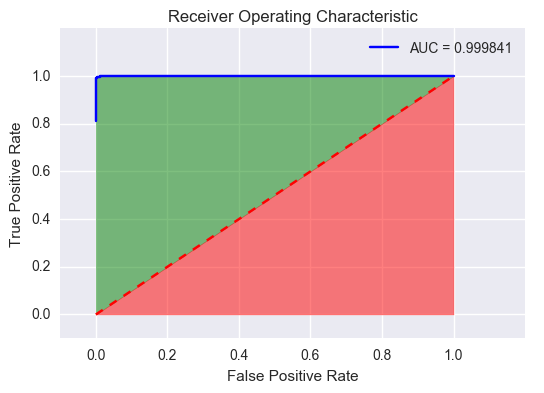

In [25]:
prediction_probabilities = svc.predict_proba(X_test)

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, prediction_probabilities[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('Receiver Operating Characteristic')
plt.plot(false_positive_rate, true_positive_rate, 'b',
label='AUC = %0.6f'% roc_auc)
plt.legend(loc='upper right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.fill_between(false_positive_rate, false_positive_rate, true_positive_rate, color='green', alpha=0.5)
plt.fill_between(false_positive_rate, 0*false_positive_rate, false_positive_rate, color='red',alpha=0.5)
plt.show()